# COVID19DB PROJECT (www.covid19db.org): covid19 - confirmed cases, administrative division of Poland


This notebook demonstrates how to connect to COVID19db Postgres database and how to generate country level visualisaion.

In [127]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)

cur = conn.cursor()
cur.execute("""SELECT i.* FROM
                (SELECT max(date) AS date, countrycode, adm_area_1
                FROM infections WHERE source='POL_WIKI'
                GROUP BY countrycode, adm_area_1 ) AS recent_data
            INNER JOIN infections AS i
            ON i.date=recent_data.date 
            AND i.countrycode = recent_data.countrycode
            AND i.adm_area_1 = recent_data.adm_area_1
            AND i.adm_area_1 <> ''
            ORDER by i.confirmed DESC
            """)
covid19_data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

In [128]:
covid19_data[["date", "adm_area_1", "confirmed"]].head()

,date,adm_area_1,confirmed
0,2020-04-03,Masovia (MZ; Warsaw),808
1,2020-04-04,Silesia (SL),481
2,2020-04-03,Lower Silesia (DS),400
3,2020-04-04,Lesser Poland (MA),276
4,2020-04-03,Łódź (LD),248


In [129]:
voivodeship_mapping = {
    'Dolnoslaskie': 'Lower Silesia (DS)',
    'Kujawsko-Pomorskie': 'Kuyavia-Pomerania (KP)',
    'Lódzkie': 'Łódź (LD)',
    'Lubelskie': 'Lublin (LU)',
    'Lubuskie': 'Lubusz (LB)',
    'Malopolskie': 'Lesser Poland (MA)',
    'Mazowieckie': 'Masovia (MZ; Warsaw)',
    'Opolskie': 'Opole (OP)',
    'Podkarpackie': 'Subcarpathian (PK)',
    'Podlaskie': 'Podlaskie (PD)',
    'Pomorskie': 'Pomerania (PM)',
    'Slaskie': 'Silesia (SL)',
    'Warminsko-Mazurskie': 'Warmia–Masuria (WN)',
    'Wielkopolskie': 'Greater Poland (WP)',
    'Zachodniopomorskie': 'West Pomerania (ZP)',
    'Swietokrzyskie': 'Holy Cross (SK)'  
}

In [144]:
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Polygon

In [145]:
poland = geopandas.read_file("http://biogeo.ucdavis.edu/data/diva/adm/POL_adm.zip", layer='POL_adm1')
poland["ENGNAME_1"] = poland["VARNAME_1"].map(voivodeship_mapping)
poland.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry,ENGNAME_1
0,181,POL,Poland,1,Łódź,Województwo,Voivodeship|Province,None,Lódzkie,"POLYGON ((19.34231 52.30919, 19.36254 52.29567...",Łódź (LD)
1,181,POL,Poland,2,Świętokrzyskie,Województwo,Voivodeship|Province,None,Swietokrzyskie,"POLYGON ((20.70706 51.14639, 20.71060 51.14365...",Holy Cross (SK)
2,181,POL,Poland,3,Greater Poland,Województwo,Voivodeship|Province,None,Wielkopolskie,"POLYGON ((16.92182 53.59652, 16.94773 53.58820...",Greater Poland (WP)
3,181,POL,Poland,4,Kuyavian-Pomeranian,Województwo,Voivodeship|Province,None,Kujawsko-Pomorskie,"POLYGON ((18.25566 53.69423, 18.27436 53.67850...",Kuyavia-Pomerania (KP)
4,181,POL,Poland,5,Lesser Poland,Województwo,Voivodeship|Province,None,Malopolskie,"POLYGON ((20.15906 50.43463, 20.17673 50.43217...",Lesser Poland (MA)


In [146]:
poland = poland.merge(
    covid19_data[['adm_area_1','tested','confirmed']], 
    how = 'left', left_on = 'ENGNAME_1', right_on = 'adm_area_1'
)
# add centroids 
poland['coords'] = poland['geometry'].apply(lambda x: x.centroid.coords[:])
poland['coords'] = [coords[0] for coords in poland['coords']]

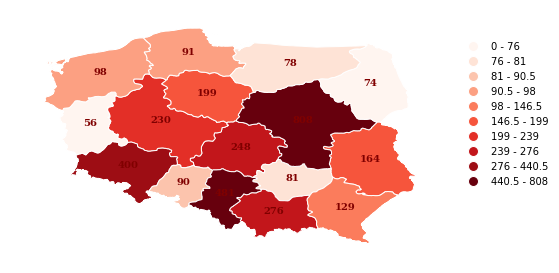

In [153]:
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import geoplot as gplt


schema = mc.Quantiles(poland['confirmed'], k=10)
gplt.choropleth(
    poland,     
    hue='confirmed',     
    edgecolor='white', 
    linewidth=1,
    cmap='Reds',
    scheme=schema,
    legend=True, 
    legend_kwargs={'bbox_to_anchor': (1, 0.9), 'frameon': False},
)

for _, row in poland.iterrows():
  hue = round(row['confirmed'],2)  
  plt.text(s=row['confirmed'], x = row['coords'][0], y = row['coords'][1],
           horizontalalignment='center', 
           fontdict = {'weight': 'bold', 'size': 10, 'family': 'serif', 'color':  'maroon',})